In [1]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install langdetect
from langdetect import detect
import re
import requests
import spacy
from tqdm import tqdm
import ast
from collections import Counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=19cb56937c97b43d4b67ce7a6d5f9e4b4761f0a33990080602267506b914dcbf
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка данных

In [65]:
df = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_uncleaned.csv')
df_reviews = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_uncleaned.csv')

In [4]:
print("Number of uncleaned Airbnbs: ", len(df))
print("Number of uncleaned Reviews: ", len(df_reviews))

Number of uncleaned Airbnbs:  7492
Number of uncleaned Reviews:  311785


## Очистка

### Удаление дублей

In [5]:
duplicate_urls = df.duplicated(subset='url', keep='first')
count_duplicate_urls = sum(duplicate_urls)
print("Number of duplicate Airbnbs:", count_duplicate_urls)
duplicate_ids = df_reviews.duplicated(subset='review_id', keep='first')
count_duplicate_ids = sum(duplicate_ids)
print("Number of duplicate Reviews:", count_duplicate_ids)

Number of duplicate Airbnbs: 0
Number of duplicate Reviews: 1268


In [6]:
duplicate_rows = df_reviews.duplicated(subset='review_id', keep=False)
duplicates = df_reviews[duplicate_rows]
duplicates_sorted = duplicates.sort_values(by='review_id')
print(duplicates_sorted.head(4))

                                        review_comments review_createdAt  \
1319  The host was present on our arrival. We were a...              NaN   
1320  <br/>We were quite shocked that the place was ...              NaN   
1321  <br/>When we made our coffee in the morning we...              NaN   
1322  <br/>The small window was held open with a blo...              NaN   

      review_id  review_rating review_language review_localizedDate  \
1319        NaN            NaN             NaN                  NaN   
1320        NaN            NaN             NaN                  NaN   
1321        NaN            NaN             NaN                  NaN   
1322        NaN            NaN             NaN                  NaN   

      review_author.id review_localizedReview.disclaimer  url name  stars  \
1319               NaN                               NaN  NaN  NaN    NaN   
1320               NaN                               NaN  NaN  NaN    NaN   
1321               NaN          

In [7]:
duplicate_rows = df.duplicated(subset='url', keep=False)
duplicates = df[duplicate_rows]
duplicates_sorted = duplicates.sort_values(by='url')
print(duplicates_sorted.head(4))

Empty DataFrame
Columns: [url, name, stars, numberOfGuests, address, pricing, primaryHost, isHostedBySuperhost, lat, lng]
Index: []


In [8]:
print("Original number of Airbnbs: ", len(df))
df = df.drop_duplicates(subset='url')
print("Number of Airbnbs without duplicates (based on url): ", len(df))
print("Original number of reviews: ", len(df_reviews))
df_reviews = df_reviews.drop_duplicates(subset='review_id')
print("Number of reviews without duplicates (based on review id): ", len(df_reviews))

Original number of Airbnbs:  7492
Number of Airbnbs without duplicates (based on url):  7492
Original number of reviews:  311785
Number of reviews without duplicates (based on review id):  310517


In [9]:
duplicate_rows_name_location = df.duplicated(subset=['name', 'lat', 'lng'], keep="first")
count_duplicate_urls_name_location= sum(duplicate_rows_name_location)
print("Number of duplicate Airbnbs by name & location:", count_duplicate_urls_name_location)

Number of duplicate Airbnbs by name & location: 44


In [10]:
duplicates_name_location = df[duplicate_rows_name_location]
duplicates_name_location_sorted = duplicates_name_location.sort_values(by=['name', 'lat', 'lng'])
print(duplicates_name_location_sorted.head(4))

                                        url  \
3157  https://www.airbnb.com/rooms/42749901   
3198  https://www.airbnb.com/rooms/42269923   
3543  https://www.airbnb.com/rooms/42750024   
3165  https://www.airbnb.com/rooms/42786231   

                                           name  stars  numberOfGuests  \
3157  1-Raum Erdgeschoss "Breezy Garden", 51 qm    NaN               3   
3198  1-Raum Erdgeschoss "Breezy Garden", 51 qm    NaN               3   
3543  1-Raum Erdgeschoss "Breezy Garden", 51 qm    NaN               3   
3165                2-Raum "Blue Lagoon", 60 qm    NaN               3   

              address                                            pricing  \
3157  Berlin, Germany  {'rate': {'amount': 255, 'is_micros_accuracy':...   
3198  Berlin, Germany  {'rate': {'amount': 264, 'is_micros_accuracy':...   
3543  Berlin, Germany  {'rate': {'amount': 226, 'is_micros_accuracy':...   
3165  Berlin, Germany  {'rate': {'amount': 288, 'is_micros_accuracy':...   

            

In [11]:
print("Original number of Airbnbs: ", len(df))
df = df.drop_duplicates(subset=['name', 'lat', 'lng'])
print("Number of Airbnbs without duplicates (based on name & location): ", len(df))
unique_urls = df['url'].unique()
df_reviews = df_reviews[df_reviews['url'].isin(unique_urls)]
print("Original number of Reviews: ", len(df_reviews))
print("Number of Reviews without duplicates (based on name & location):", len(df_reviews))

Original number of Airbnbs:  7492
Number of Airbnbs without duplicates (based on name & location):  7448
Original number of Reviews:  309780
Number of Reviews without duplicates (based on name & location): 309780


### Язык

Удаляем все, которые в оригинале были не на английском



In [12]:
num_nottranslated= df_reviews["review_localizedReview.disclaimer"].isna().sum()
print("Number of Reviews in originally English: ", num_nottranslated)
num_translated= df_reviews["review_localizedReview.disclaimer"].notnull().sum()
print("Number of Reviews in not originally English: ", num_translated)

Number of Reviews in originally English:  250584
Number of Reviews in not originally English:  59196


In [13]:
df_reviews_nottranslated = df_reviews[df_reviews["review_localizedReview.disclaimer"].isna()]
df_nottranslated = df[df["url"].isin(df_reviews["url"])]

In [14]:
print("Number of Reviews after filtering for translation: ", len(df_reviews_nottranslated), "before: ", len(df_reviews))
print("Number of Aribnbs after filtering for translation: ", len(df_nottranslated), "before: ", len(df))

Number of Reviews after filtering for translation:  250584 before:  309780
Number of Aribnbs after filtering for translation:  6741 before:  7448


In [15]:
print(df_reviews_nottranslated["review_localizedReview.disclaimer"].value_counts())
df_reviews_nottranslated = df_reviews_nottranslated.drop(columns=["review_localizedReview.disclaimer"])

Series([], Name: count, dtype: int64)


Определяем язык и удаляем все, которые не на английском

In [16]:
tqdm.pandas()
def detect_language(text):
    try:
        return detect(text)
    except:
        return None
df_reviews_nottranslated = df_reviews_nottranslated.reset_index(drop=True)
split_idx = len(df_reviews_nottranslated) // 2
df_reviews_nottranslated.loc[:split_idx, 'language'] = df_reviews_nottranslated.loc[:split_idx, 'review_comments'].progress_apply(detect_language)

100%|██████████| 125293/125293 [12:53<00:00, 161.93it/s]


In [17]:
df_reviews_nottranslated.loc[(split_idx + 1):, 'language'] = df_reviews_nottranslated.loc[(split_idx + 1):, 'review_comments'].progress_apply(detect_language)

100%|██████████| 125291/125291 [14:38<00:00, 142.69it/s]


In [18]:
print(df_reviews_nottranslated['language'].value_counts())

language
en       246344
ro          597
fr          484
so          358
af          347
ca          331
cy          213
id          151
it          150
cs          139
tl          128
de          122
nl          111
es           81
pl           77
no           72
sw           67
hr           50
da           42
hu           41
fi           31
sv           27
sl           26
vi           23
et           21
pt           18
sk           17
tr           13
lv            4
ru            4
he            3
sq            3
ja            1
lt            1
zh-cn         1
ko            1
ar            1
Name: count, dtype: int64


In [19]:
df_reviews_nottranslated = df_reviews_nottranslated[df_reviews_nottranslated['language'] == 'en']
rev_urls_en = df_reviews_nottranslated['url'].unique()
df_nottranslated = df_nottranslated[df_nottranslated['url'].isin(rev_urls_en)]
print(len(df_reviews_nottranslated), len(df_nottranslated))
print(df_reviews_nottranslated.columns)
print(df_nottranslated.columns)

246344 6547
Index(['review_comments', 'review_createdAt', 'review_id', 'review_rating',
       'review_language', 'review_localizedDate', 'review_author.id', 'url',
       'name', 'stars', 'numberOfGuests', 'isHostedBySuperhost', 'language'],
      dtype='object')
Index(['url', 'name', 'stars', 'numberOfGuests', 'address', 'pricing',
       'primaryHost', 'isHostedBySuperhost', 'lat', 'lng'],
      dtype='object')


In [20]:
df_reviews = df_reviews_nottranslated.copy()
df = df_nottranslated.copy()
df_reviews.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_uncleaned1.csv', index=False)
df.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_uncleaned1.csv', index=False)

In [21]:
print("Example comment: ", df_reviews['review_comments'][62])

Example comment:  Thanks for the stay! I can’t think of anything we would do differently


### Очистка отзывов

Удаляем переносы строк, специальные символы

In [22]:
def remove_special_chars(text):
    cleaned_text = re.sub('<br/>|[\W\d]+', ' ', text)
    cleaned_text = re.sub(r'\bbr\b', '', cleaned_text)
    cleaned_text = re.sub(' +', ' ', cleaned_text)
    return cleaned_text
df_reviews['review_comments'] = df_reviews['review_comments'].astype(str)
df_reviews['review_comments'] = df_reviews['review_comments'].apply(remove_special_chars)

In [23]:
print(df_reviews['review_comments'][:10])

0                Everything was perfect nice and clean
1    The appartment was beautifull and Mark was ver...
2    we spent excellent nights in this apartment Co...
3    Brid was a brilliant house and an amazing hous...
4    Great host super responsive Made our stay in D...
5    Sarah s property is a great location and base ...
6    A quiet neigborhood that you can arrive with n...
7    Great place in a beautiful location Goran and ...
8                       Lovely little place very cosy 
9             Little gem of a place Very warm and cozy
Name: review_comments, dtype: object


Также удаляем локацию

In [24]:
count_london_old = df_reviews['review_comments'].str.count(r'\blondon\b', flags=re.IGNORECASE).sum()
print("The word 'London' occurs before removal", count_london_old, "times in review_comments.")
count_germany_old = df_reviews['review_comments'].str.count(r'\bgermany\b', flags=re.IGNORECASE).sum()
print("The word 'Germany' occurs before removal", count_germany_old, "times in review_comments.")
count_munich_old = df_reviews['review_comments'].str.count(r'\bmunich\b', flags=re.IGNORECASE).sum()
print("The word 'Munich' occurs before removal", count_munich_old, "times in review_comments.")
count_paris_old = df_reviews['review_comments'].str.count(r'\bparis\b', flags=re.IGNORECASE).sum()
print("The word 'Paris' occurs before removal", count_paris_old, "times in review_comments.")

The word 'London' occurs before removal 3812 times in review_comments.
The word 'Germany' occurs before removal 347 times in review_comments.
The word 'Munich' occurs before removal 4508 times in review_comments.
The word 'Paris' occurs before removal 12925 times in review_comments.


Удаление имен и локаций с помощью Spacy

In [25]:
nlp = spacy.load('en_core_web_sm')
def remove_location(text):
    doc = nlp(text)
    cleaned_tokens = [token.text if token.ent_type_ not in ['GPE', 'PERSON'] or token.ent_type_.lower() not in ['gpe', 'person'] else '' for token in doc]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

In [26]:
df_reviews_noloc = df_reviews.copy()
num_rows = len(df_reviews_noloc)
tqdm.pandas(total=num_rows)
df_reviews_noloc['review_comments']= df_reviews_noloc['review_comments'].progress_apply(remove_location)
print(df_reviews_noloc['review_comments'][:10])

100%|██████████| 246344/246344 [1:04:30<00:00, 63.64it/s]


0                Everything was perfect nice and clean
1    The appartment was beautifull and  was very fr...
2    we spent excellent nights in this apartment  g...
3     was a brilliant house and an amazing house as...
4    Great host super responsive Made our stay in  ...
5     s property is a great location and base for t...
6    A quiet neigborhood that you can arrive with n...
7    Great place in a beautiful location  and  were...
8                        Lovely little place very cosy
9             Little gem of a place Very warm and cozy
Name: review_comments, dtype: object


In [167]:
count_london = df_reviews_noloc['review_comments'].str.count(r'\blondon\b', flags=re.IGNORECASE).sum()
print("The word 'London' occurs", count_london, "times in review_comments.")
count_munich = df_reviews_noloc['review_comments'].str.count(r'\bMunich\b', flags=re.IGNORECASE).sum()
print("The word 'Munich' occurs", count_munich, "times in review_comments.")
count_paris = df_reviews_noloc['review_comments'].str.count(r'\bParis\b', flags=re.IGNORECASE).sum()
print("The word 'Paris' occurs", count_paris, "times in review_comments.")
count_dublin = df_reviews_noloc['review_comments'].str.count(r'\bDublin\b', flags=re.IGNORECASE).sum()
print("The word 'Dublin' occurs", count_dublin, "times in review_comments.")
count_dublin = df_reviews_noloc['review_comments'].str.count(r'\bBerlin\b', flags=re.IGNORECASE).sum()
print("The word 'Berlin' occurs", count_dublin, "times in review_comments.")

The word 'London' occurs 339 times in review_comments.
The word 'Munich' occurs 245 times in review_comments.
The word 'Paris' occurs 1230 times in review_comments.
The word 'Dublin' occurs 4392 times in review_comments.
The word 'Berlin' occurs 896 times in review_comments.


In [28]:
df_reviews = df_reviews_noloc.copy()
df_reviews.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_uncleaned2.csv', index=False)
df.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_uncleaned2.csv', index=False)

In [116]:
df = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_uncleaned2.csv')
df_reviews = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_uncleaned2.csv')

In [117]:
df_reviews['review_comments'] = df_reviews['review_comments'].astype(str)

Нижний регистр

In [118]:
def convert_to_lowercase(text):
    text = text.lower()
    return text

In [119]:
df_reviews['review_comments'] = df_reviews['review_comments'].apply(convert_to_lowercase)
print(df_reviews['review_comments'][:10])

0                everything was perfect nice and clean
1    the appartment was beautifull and  was very fr...
2    we spent excellent nights in this apartment  g...
3     was a brilliant house and an amazing house as...
4    great host super responsive made our stay in  ...
5     s property is a great location and base for t...
6    a quiet neigborhood that you can arrive with n...
7    great place in a beautiful location  and  were...
8                        lovely little place very cosy
9             little gem of a place very warm and cozy
Name: review_comments, dtype: object


### Пропуски

In [120]:
null_counts_df = df.isnull().sum()
print("Null value counts in df:\n", null_counts_df)

Null value counts in df:
 url                      0
name                     0
stars                  427
numberOfGuests           0
address                  0
pricing                  0
primaryHost              0
isHostedBySuperhost      0
lat                      0
lng                      0
dtype: int64


In [121]:
columns_to_check = ["stars", "name", "url", "numberOfGuests"]
df = df.dropna(subset=columns_to_check, how="any")
df = df[~(df[columns_to_check] == 0).any(axis=1)]
df = df.reset_index(drop=True)

In [122]:
empty_entries = df_reviews['review_comments'].str.strip().eq('')
print(df_reviews[empty_entries])

       review_comments          review_createdAt     review_id  review_rating  \
14091                   2015-05-24T13:23:48.000Z  3.297719e+07            4.0   
26396                   2023-12-25T13:27:31.000Z  1.054230e+18            5.0   
28097                   2023-09-04T15:53:17.000Z  9.731288e+17            5.0   
54426                   2016-08-20T05:50:16.000Z  9.550776e+07            5.0   
63559                   2016-04-03T09:27:31.000Z  6.826005e+07            5.0   
70980                   2024-05-04T13:44:00.000Z  1.149184e+18            5.0   
118397                  2015-12-13T12:42:45.000Z  5.638993e+07            5.0   
119288                  2021-11-12T15:50:07.000Z  4.940505e+17            4.0   
128104                  2023-10-07T13:03:46.000Z  9.969611e+17            5.0   
143378                  2023-06-11T12:19:24.000Z  9.114152e+17            5.0   
192345                  2021-07-23T13:55:28.000Z  4.128179e+17            4.0   
237798                  2022

In [123]:
null_counts_df = df.isnull().sum()
print("Null value counts in df:\n", null_counts_df)

Null value counts in df:
 url                    0
name                   0
stars                  0
numberOfGuests         0
address                0
pricing                0
primaryHost            0
isHostedBySuperhost    0
lat                    0
lng                    0
dtype: int64


In [124]:
null_counts_df_reviews = df_reviews.isnull().sum()
print("Null value counts in df:\n", null_counts_df_reviews)

Null value counts in df:
 review_comments             0
review_createdAt            0
review_id                   0
review_rating               0
review_language         75587
review_localizedDate        0
review_author.id            0
url                         0
name                        0
stars                     562
numberOfGuests              0
isHostedBySuperhost         0
language                    0
dtype: int64


In [125]:
common_urls = set(df['url']).intersection(set(df_reviews['url']))
df = df[df['url'].isin(common_urls)]
df_reviews = df_reviews[df_reviews['url'].isin(common_urls)]
df = df.reset_index(drop=True)
df_reviews = df_reviews.reset_index(drop=True)

In [126]:
null_counts_df_reviews = df_reviews.isnull().sum()
print("Null value counts in df:\n", null_counts_df_reviews)

Null value counts in df:
 review_comments             0
review_createdAt            0
review_id                   0
review_rating               0
review_language         75450
review_localizedDate        0
review_author.id            0
url                         0
name                        0
stars                       0
numberOfGuests              0
isHostedBySuperhost         0
language                    0
dtype: int64


In [127]:
df_reviews["review_rating"].value_counts()

review_rating
5.0    211416
4.0     27731
3.0      5031
2.0       870
1.0       584
0.0       150
Name: count, dtype: int64

In [128]:
missing_comments = df_reviews['review_rating'].isnull() | (df_reviews['review_rating'] == 'NAN') | (df_reviews['review_rating'] == 'NaN') | (df_reviews['review_rating'] == '') | (df_reviews['review_rating'] == ' ')
count_missing_comments = missing_comments.sum()
if count_missing_comments > 0:
    print("There are missing or empty values in the 'review_rating' column.")
else:
    print("The 'review_rating' column does not contain missing or empty values.")

The 'review_rating' column does not contain missing or empty values.


Оценка (число звездочек)

In [129]:
df["stars"].value_counts()

stars
5.00    2991
4.50     642
4.90     102
4.92      99
4.95      98
        ... 
3.80       1
4.31       1
3.33       1
4.26       1
4.09       1
Name: count, Length: 96, dtype: int64

In [130]:
missing_stars = df['stars'].isnull() | (df['stars'] == 'NAN') | (df['stars'] == 'NaN') | (df['stars'] == '') | (df['stars'] == ' ')
count_missing_stars = missing_stars.sum()
if count_missing_stars > 0:
    print("There are missing or empty values in the 'stars' column.")
else:
    print("The 'stars' column does not contain missing or empty values.")

The 'stars' column does not contain missing or empty values.


Супер хост

In [131]:
df["isHostedBySuperhost"].value_counts()

isHostedBySuperhost
False    3142
True     2978
Name: count, dtype: int64

### Цена

In [132]:
currencies = []
for pricing in df['pricing']:
    pricing_dict = ast.literal_eval(pricing)
    if 'rate' in pricing_dict and 'currency' in pricing_dict['rate']:
        currency = pricing_dict['rate']['currency']
        currencies.append(currency)
currency_counts = Counter(currencies)
print(currency_counts)

Counter()


In [133]:
df['pricing'] = df['pricing'].apply(ast.literal_eval)
df['price'] = df['pricing'].apply(lambda x: x['rate']['amount'])
df = df.drop(columns=["pricing"])
df['price_per_guest'] = df['price'] / df['numberOfGuests']

### Проверка на выбросы

По цене

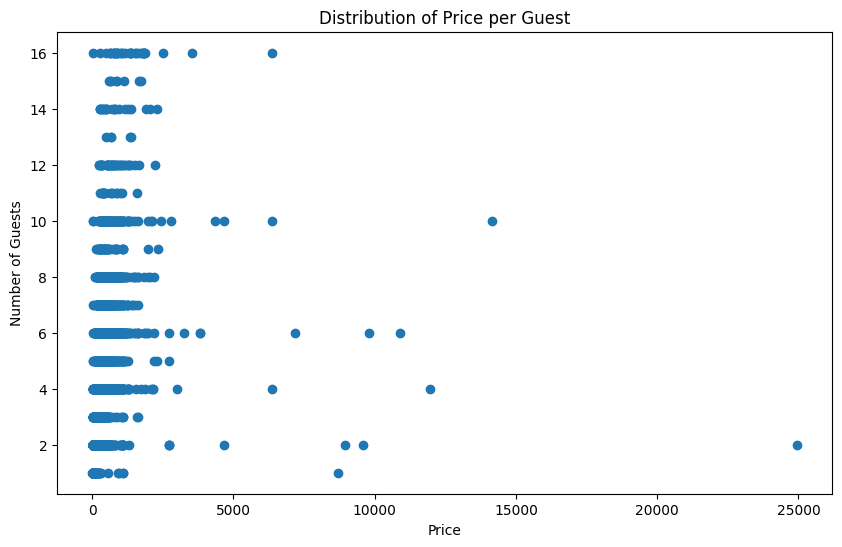

In [135]:
df_price = df['price'].dropna()
plt.figure(figsize=(10, 6))
plt.scatter(df["price"], df['numberOfGuests'], marker='o')
plt.xlabel('Price')
plt.ylabel('Number of Guests')
plt.title('Distribution of Price per Guest')
plt.show()

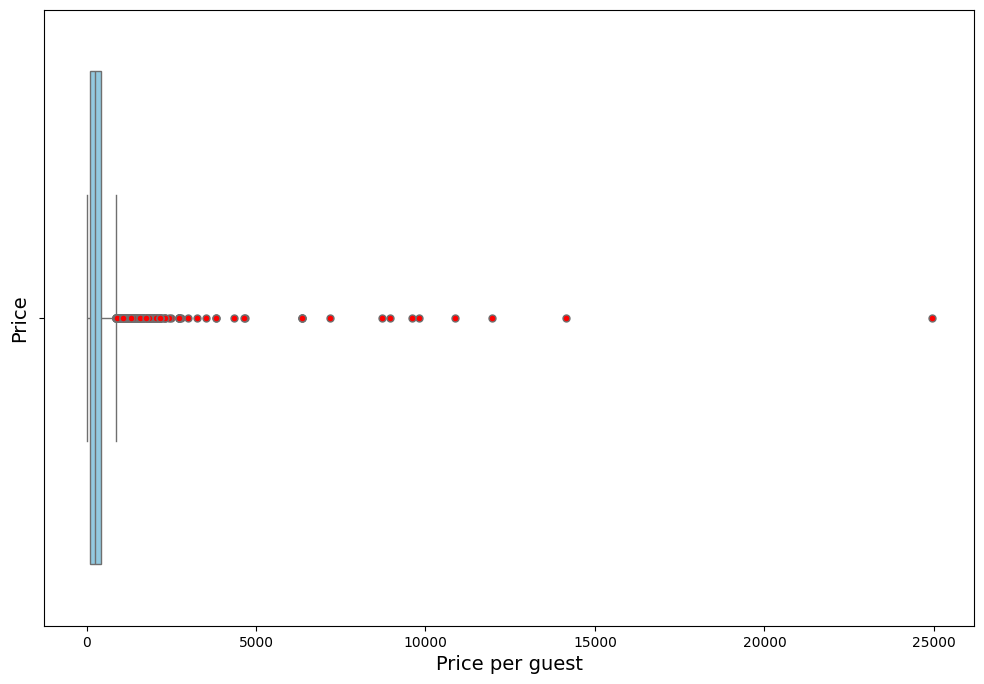

In [136]:
plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(x=df_price, color='skyblue', flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 5})
for i, artist in enumerate(boxplot.artists):
    if i > 0 and i <= 20:
        artist.set_facecolor('red')
plt.xlabel('Price per guest', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()

In [138]:
extreme_outliers = df[df['price_per_guest'] > 1500]
print(extreme_outliers)
df_reviews_extreme_outliers = df_reviews[df_reviews['url'].isin(extreme_outliers['url'])]
print(df_reviews_extreme_outliers['review_comments'])

                                        url  \
32    https://www.airbnb.com/rooms/26127067   
3464  https://www.airbnb.com/rooms/29587660   
3466  https://www.airbnb.com/rooms/53088234   
3469  https://www.airbnb.com/rooms/25877521   
4385  https://www.airbnb.com/rooms/32740447   
4387  https://www.airbnb.com/rooms/20031208   
4389  https://www.airbnb.com/rooms/25230487   
5375  https://www.airbnb.com/rooms/38374761   
5376  https://www.airbnb.com/rooms/25961730   

                                                  name  stars  numberOfGuests  \
32         Private ensuite bedroom \n3 km from Airport   4.83               2   
3464                Luxury 5-star Flat with Art & Tech   5.00               2   
3466   Spacious 2 Bed Home in Picturesque East Molesey   5.00               4   
3469  Double Room with King Size Bed near Tower Bridge   5.00               2   
4385                      La Maison Eiffel - Trocadero   5.00               2   
4387            Duplex Loft ‘Like a house’ 

In [139]:
print("Oirginal number of Airbnbs: ", len(df))
df = df[~df['url'].isin(extreme_outliers['url'])]
print("After filtering outliers by price: ", len(df))
print("Number of removed Airbnbs: ", len(extreme_outliers))
print("Oirginal number of Comments: ", len(df_reviews))
df_reviews = df_reviews[df_reviews['url'].isin(df['url'])]
print("After filtering outliers by price: ", len(df_reviews))

Oirginal number of Airbnbs:  6120
After filtering outliers by price:  6111
Number of removed Airbnbs:  9
Oirginal number of Comments:  245782
After filtering outliers by price:  245665


In [140]:
extreme_outliers2 = df[df['price_per_guest'] > 400]
df_reviews_extreme_outliers2 = df_reviews[df_reviews['url'].isin(extreme_outliers2['url'])]
print("Oirginal number of Airbnbs: ", len(df))
df_ex2 = df[~df['url'].isin(extreme_outliers2['url'])]
print("After filtering outliers by price: ", len(df_ex2))
print("Number of removed Airbnbs: ", len(extreme_outliers2))
print("Oirginal number of Comments: ", len(df_reviews))
df_reviews_ext2 = df_reviews[df_reviews['url'].isin(df_ex2['url'])]
print("After filtering outliers by price: ", len(df_reviews_ext2))
print(len(df_reviews_ext2)- len(df_reviews))

Oirginal number of Airbnbs:  6111
After filtering outliers by price:  6068
Number of removed Airbnbs:  43
Oirginal number of Comments:  245665
After filtering outliers by price:  244176
-1489


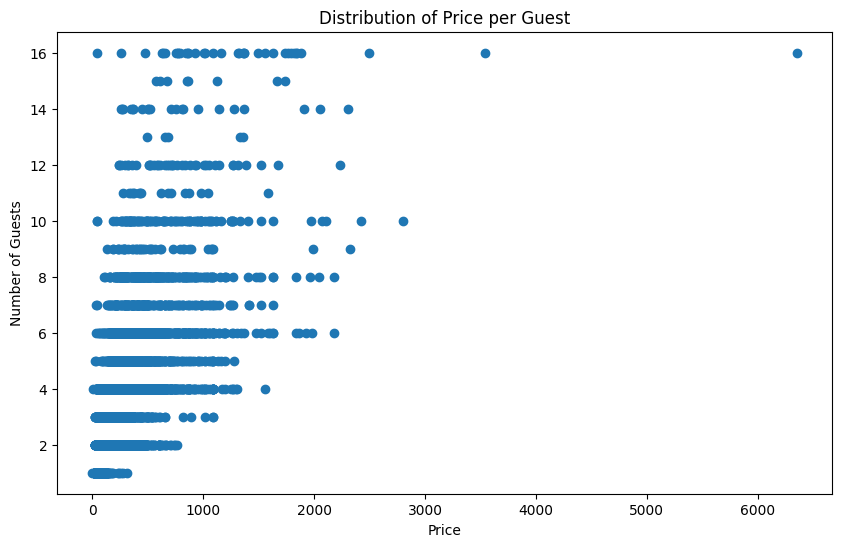

In [141]:
plt.figure(figsize=(10, 6))
plt.scatter(df_ex2["price"], df_ex2['numberOfGuests'], marker='o')
plt.xlabel('Price')
plt.ylabel('Number of Guests')
plt.title('Distribution of Price per Guest')
plt.show()

In [142]:
df_price.describe()

count     6120.000000
mean       342.317974
std        596.014191
min          1.000000
25%        112.000000
50%        245.000000
75%        416.000000
max      24944.000000
Name: price, dtype: float64

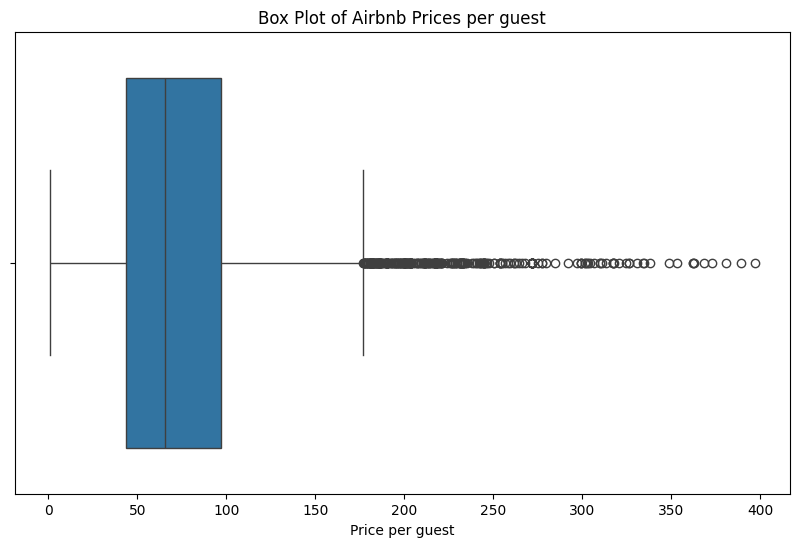

In [143]:
df_price_per_guest_ex2 = df_ex2['price_per_guest'].dropna()
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_price_per_guest_ex2)
plt.title('Box Plot of Airbnb Prices per guest')
plt.xlabel('Price per guest')
plt.show()

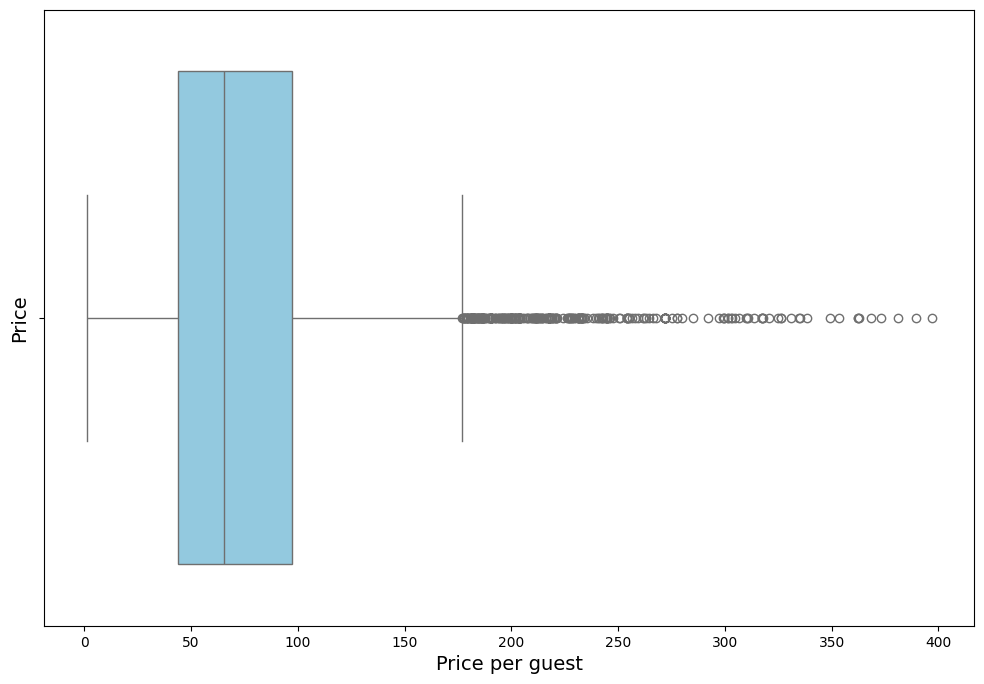

In [144]:
plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(x=df_price_per_guest_ex2, color='skyblue')
plt.xlabel('Price per guest', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()

По числу гостей

In [145]:
print(df['numberOfGuests'].describe())
print(df['numberOfGuests'].value_counts())

count    6111.00000
mean        3.98560
std         2.54391
min         1.00000
25%         2.00000
50%         4.00000
75%         5.00000
max        16.00000
Name: numberOfGuests, dtype: float64
numberOfGuests
2     1879
4     1385
6      787
1      551
5      391
3      381
8      281
7      177
10     112
9       41
12      40
16      36
14      21
11      16
15       8
13       5
Name: count, dtype: int64


### Сохранение полученных таблиц

In [146]:
df = df_ex2.copy()
df_reviews = df_reviews_ext2

In [147]:
df_reviews.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_final.csv', index=False)
df.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_final.csv', index=False)

## Удаляем нули и создаем двоичные данные

In [149]:
df_reviews_binary = df_reviews[df_reviews['review_rating'] != 0]
df_reviews_binary['review_rating'] = df_reviews_binary['review_rating'].replace({1: 'negative', 2: 'negative', 4: 'positive', 5: 'positive'})
df_reviews_binary = df_reviews_binary[df_reviews['review_rating'] != 3]
print(len(df_reviews_binary))

239031


<ipython-input-149-cdb3207dc8d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews_binary['review_rating'] = df_reviews_binary['review_rating'].replace({1: 'negative', 2: 'negative', 4: 'positive', 5: 'positive'})
<ipython-input-149-cdb3207dc8d4>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reviews_binary = df_reviews_binary[df_reviews['review_rating'] != 3]


In [150]:
review_urls = df_reviews_binary['url'].unique()
df_binary = df[df['url'].isin(review_urls)]

In [152]:
df_binary.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_final_binary.csv', index=None)
df_reviews_binary.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_final_binary.csv', index=None)

## EDA

In [153]:
df_reviews = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_final.csv')
df = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_final.csv')
df_bi = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_final_binary.csv')
df_reviews_bi = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_final_binary.csv')

In [154]:
print(len(df_reviews), len(df))
print(len(df_reviews_bi), len(df_bi))

244176 6068
239031 6068


### Отзывы

In [155]:
review_counts = df_reviews_bi.groupby('url').size()
print(review_counts.describe())

count    6068.000000
mean       39.392057
std        62.656894
min         1.000000
25%        10.000000
50%        18.000000
75%        47.000000
max       973.000000
dtype: float64


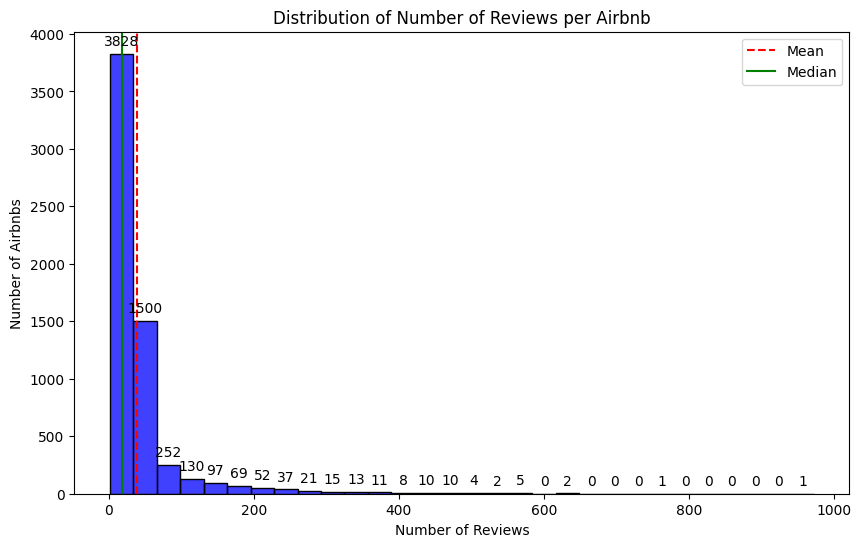

In [156]:
mean_count = np.mean(review_counts)
median_count = np.median(review_counts)
plt.figure(figsize=(10,6))
histplot = sns.histplot(review_counts, bins=30, kde=False, color='blue')
for p in histplot.patches:
    histplot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.axvline(mean_count, color='red', linestyle='--')
plt.axvline(median_count, color='green', linestyle='-')
plt.legend({'Mean':mean_count,'Median':median_count})
plt.title('Distribution of Number of Reviews per Airbnb')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Airbnbs')
plt.show()

Число слов

count    239031.000000
mean         43.623819
std          41.225730
min           0.000000
25%          16.000000
50%          32.000000
75%          58.000000
max        1025.000000
Name: review_length, dtype: float64


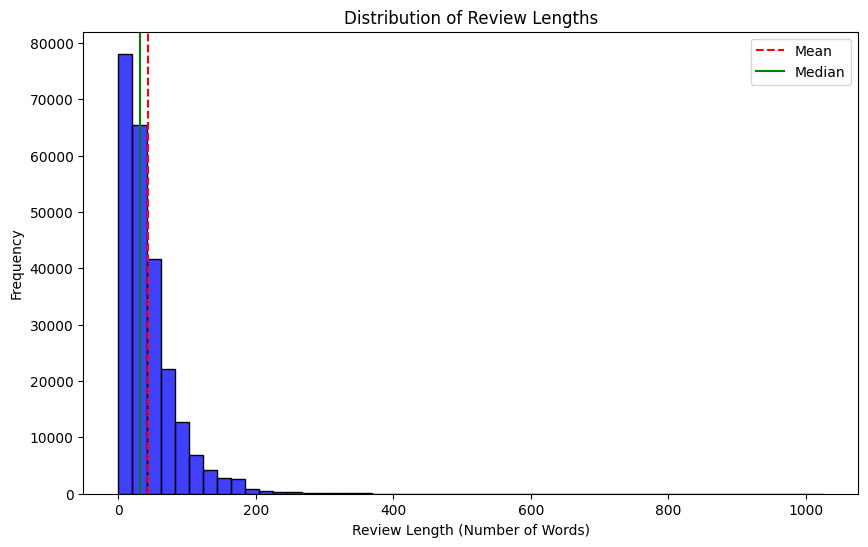

In [157]:
df_reviews_bi['review_length'] = df_reviews_bi['review_comments'].apply(lambda x: len(x.split()))
review_length_stats = df_reviews_bi['review_length'].describe()
print(review_length_stats)
review_lengths = df_reviews_bi['review_length']
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)
plt.figure(figsize=(10,6))
histplot = sns.histplot(review_lengths, bins=50, kde=False, color='blue', edgecolor='black')
plt.axvline(mean_length, color='red', linestyle='--')
plt.axvline(median_length, color='green', linestyle='-')
plt.legend({'Mean':mean_length,'Median':median_length})
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

### Оценки

In [158]:
print(df_reviews['review_rating'].value_counts())

review_rating
5.0    210067
4.0     27522
3.0      4999
2.0       865
1.0       577
0.0       146
Name: count, dtype: int64


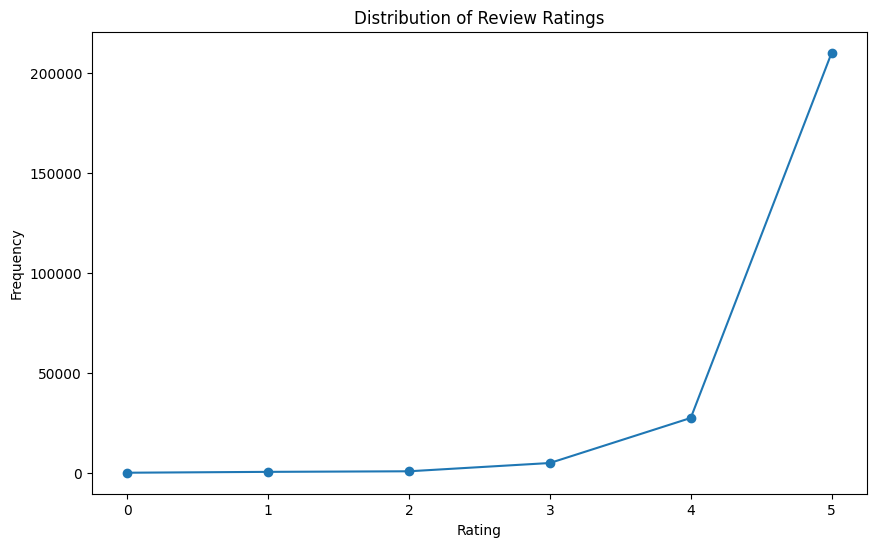

In [159]:
rating_counts = df_reviews['review_rating'].value_counts()
rating_counts = rating_counts.sort_index()
plt.figure(figsize=(10, 6))
plt.plot(rating_counts.index, rating_counts.values, marker='o')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Review Ratings')
plt.show()

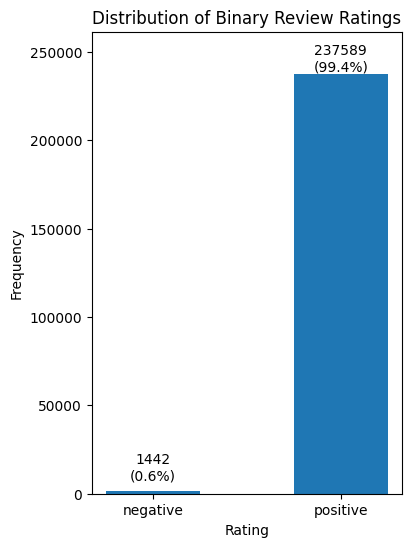

In [160]:
rating_counts2 = df_reviews_bi['review_rating'].value_counts()
rating_counts2 = rating_counts2.sort_index()
total_reviews2 = len(df_reviews_bi)
percentages2 = (rating_counts2 / total_reviews2) * 100
plt.figure(figsize=(4, 6))
plt.bar(rating_counts2.index, rating_counts2.values, align='center',  width=0.5)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Binary Review Ratings')
for i, value in enumerate(rating_counts2.values):
    if i == len(rating_counts2.values) - 1:
        plt.text(i, value, f"{value}\n({percentages2[i]:.1f}%)", ha='center', va='bottom')
    else:
        plt.text(i, value + 0.02* max(rating_counts2.values), f"{value}\n({percentages2[i]:.1f}%)", ha='center', va='bottom')
plt.ylim(0, max(rating_counts2.values) * 1.1)
plt.show()

### Супер хост

In [161]:
superhost_counts = df_bi['isHostedBySuperhost'].value_counts()
print(superhost_counts)

isHostedBySuperhost
False    3094
True     2974
Name: count, dtype: int64


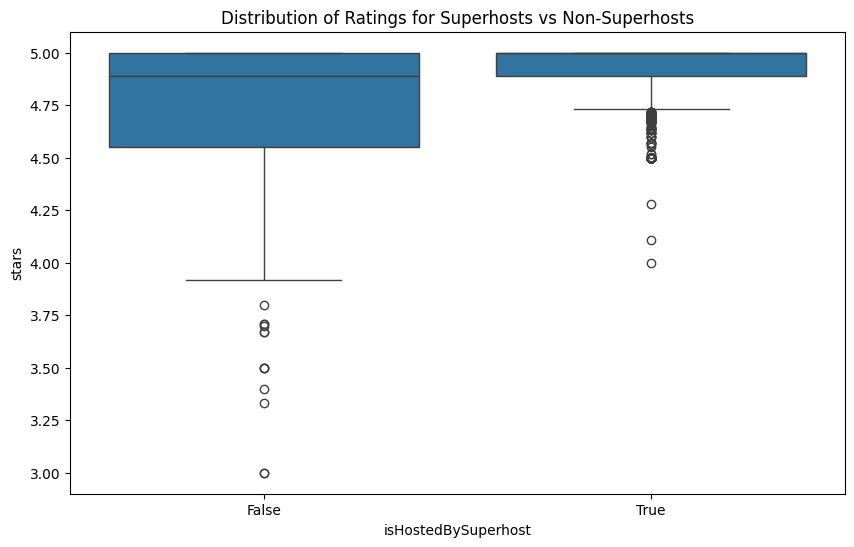

In [162]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='isHostedBySuperhost', y='stars')
plt.title('Distribution of Ratings for Superhosts vs Non-Superhosts')
plt.show()

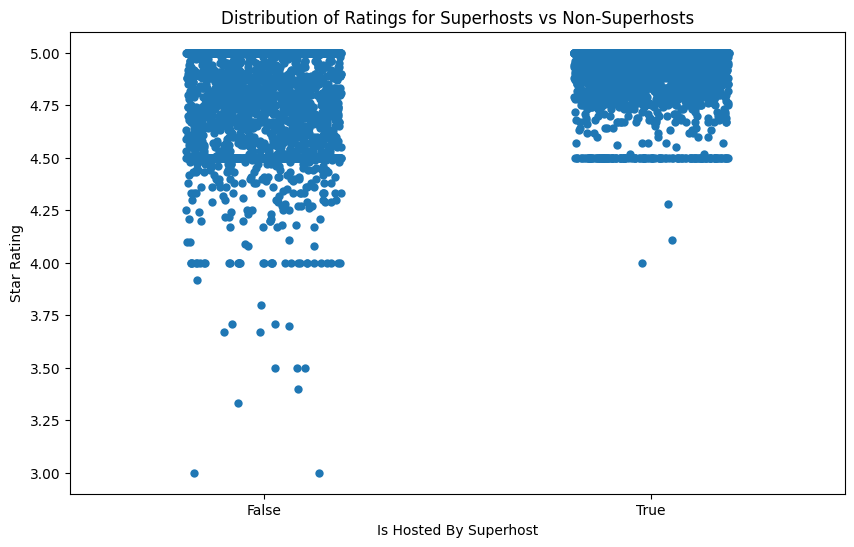

In [163]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='isHostedBySuperhost', y='stars', jitter=0.2, size=6)
plt.title('Distribution of Ratings for Superhosts vs Non-Superhosts')
plt.xlabel('Is Hosted By Superhost')
plt.ylabel('Star Rating')
plt.show()

### Цена

In [164]:
print(df_binary['price'].describe())

count    6068.000000
mean      312.682927
std       296.563230
min         1.000000
25%       110.000000
50%       241.000000
75%       413.000000
max      6352.000000
Name: price, dtype: float64


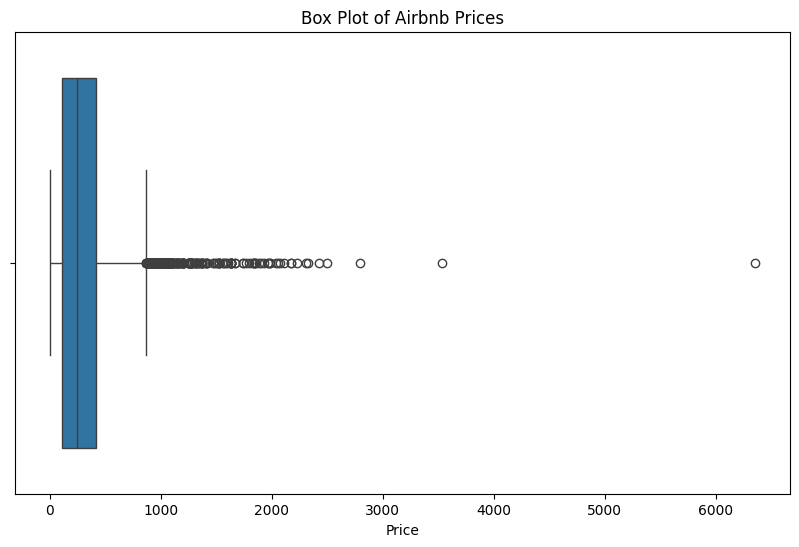

In [165]:
df_price = df_bi['price'].dropna()
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_price)
plt.title('Box Plot of Airbnb Prices')
plt.xlabel('Price')
plt.show()

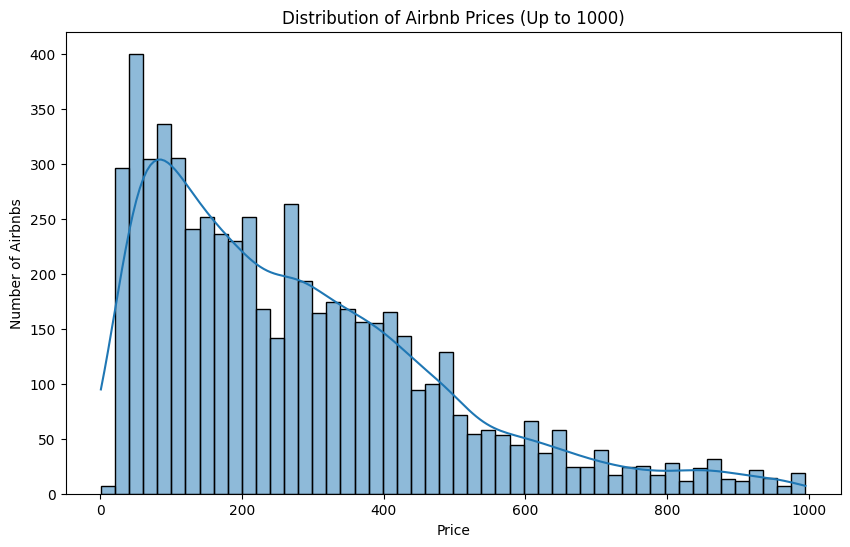

In [166]:
df_price = df_bi[df_bi['price'] <= 1000]['price'].dropna()
plt.figure(figsize=(10, 6))
sns.histplot(df_price, bins=50, kde=True)
plt.title('Distribution of Airbnb Prices (Up to 1000)')
plt.xlabel('Price')
plt.ylabel('Number of Airbnbs')
plt.show()